# Прогнозирование температуры звезды

## Описание проекта

В проекте решается задача от обсерватории «Небо на ладони»: с помощью нейросети определять температуру на поверхности обнаруженных звёзд.

Обычно для расчёта температуры ипользуются следующие методы:
- закон смещения Вина,
- закон Стефана-Больцмана,
- спектральный анализ.

Каждый из перечисленных методов имеет плюсы и минусы. Обсерватория планирует внедрить технологии машинного обучения для предсказания абсолютной температуры звёзд, рассчитывая, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.

Характеристики звезды:
- относительная светимость `L/Lo` — светимость звезды относительно Солнца,
- относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца,
- абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды,
- звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа,
- тип звезды:

| Тип звезды | Номер, соответствующий типу |
|-----------|---------|
| Коричневый карлик | 0 |
| Красный карлик | 1 |
| Белый карлик | 2 |
| Звёзды главной последовательности | 3 |
| Сверхгигант | 4 |
| Гипергигант | 5 |


- абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах. Целевой признак.

In [1]:
# В проекте будем решать задачу регрессии с помощью нейронных сетей.
# Загрузим библиотеки, которые будут использоваться
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from math import ceil

# Для разделения выборок
from sklearn.model_selection import train_test_split

# Для масштабирования и кодирования признаков
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Константы
RANDOM_STATE = 12345

## Загрузка и ознакомление с данными

In [2]:
# Загрузим данные
try:
    df = pd.read_csv('6_class.csv')
except:
    df = pd.read_csv('/datasets/6_class.csv')

In [3]:
# Рассмотрим первые строки и общие сведения
df.sample(10)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
188,2778,0.000849,0.1120,19.45,0,Red
123,3146,0.000150,0.0932,16.92,0,Red
76,2890,0.003400,0.2400,13.46,1,Red
49,33750,220000.000000,26.0000,-6.10,4,Blue
111,3605,126000.000000,1124.0000,-10.81,5,Red
233,27739,849420.000000,1252.0000,-7.59,5,Blue-white
236,30839,834042.000000,1194.0000,-10.63,5,Blue
108,24345,142000.000000,57.0000,-6.24,4,Blue
20,25000,0.056000,0.0084,10.58,2,Blue White
61,3432,0.000670,0.1900,16.94,0,Red


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


Каждый объект в наборе данных — это информация о звезде. Столбцы содержат следующую информацию (признаки):
- `Luminosity(L/Lo)` — светимость звезды относительно Солнца (относительная светимость),
- `Radius(R/Ro)` — радиус звезды относительно радиуса Солнца (относительный радиус),
- `Absolute magnitude(Mv)` — абсолютная звёздная величина (физическая величина, характеризующая блеск звезды),
- `Star type` — тип звезды,
- `Star color` — цвет звёзд,
- `Temperature (K)` — температура на поверхности звезды в Кельвинах **Целевой признак.**

## Предобработка и анализ данных

### Дубликаты

In [5]:
# Проверим полные дубликаты
df.duplicated().sum()

0

In [6]:
# Посмотрим неявные дубликаты признака Star color
df['Star color'].sort_values().unique()

array(['Blue', 'Blue ', 'Blue White', 'Blue white', 'Blue white ',
       'Blue-White', 'Blue-white', 'Orange', 'Orange-Red',
       'Pale yellow orange', 'Red', 'White', 'White-Yellow', 'Whitish',
       'Yellowish', 'Yellowish White', 'white', 'yellow-white',
       'yellowish'], dtype=object)

In [7]:
# Избавимся от неявных дубликатов
replace_map = {'Blue White':'Blue-White',
       'Blue white':'Blue-White',
       'Blue white ':'Blue-White',
       'Blue-white':'Blue-White',
       'Blue ':'Blue',
       'white':'White',
       'yellowish':'Yellowish',
       'Yellowish White':'Yellowish-White',
       'yellow-white':'Yellow-White'    
}
df['Star color'] = df['Star color'].replace(to_replace=replace_map, regex=False)

# Проверим результат
df['Star color'].sort_values().unique()

array(['Blue', 'Blue-White', 'Orange', 'Orange-Red', 'Pale yellow orange',
       'Red', 'White', 'White-Yellow', 'Whitish', 'Yellow-White',
       'Yellowish', 'Yellowish-White'], dtype=object)

Избавились от дубликатов.

### Пропуски и аномалии

Пропусков в данных нет. Рассмотрим аномалии.

#### Категориальные признаки

In [8]:
# Посмотрим значения признака Star type
df['Star type'].sort_values().unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

Аномальные данные среди категориальных признаков отсутствуют. Рассмотрим категориальные признаки подробнее.

In [9]:
# Изучим столбец с данными о типе звезды Star type
df['Star type'].value_counts()

Star type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

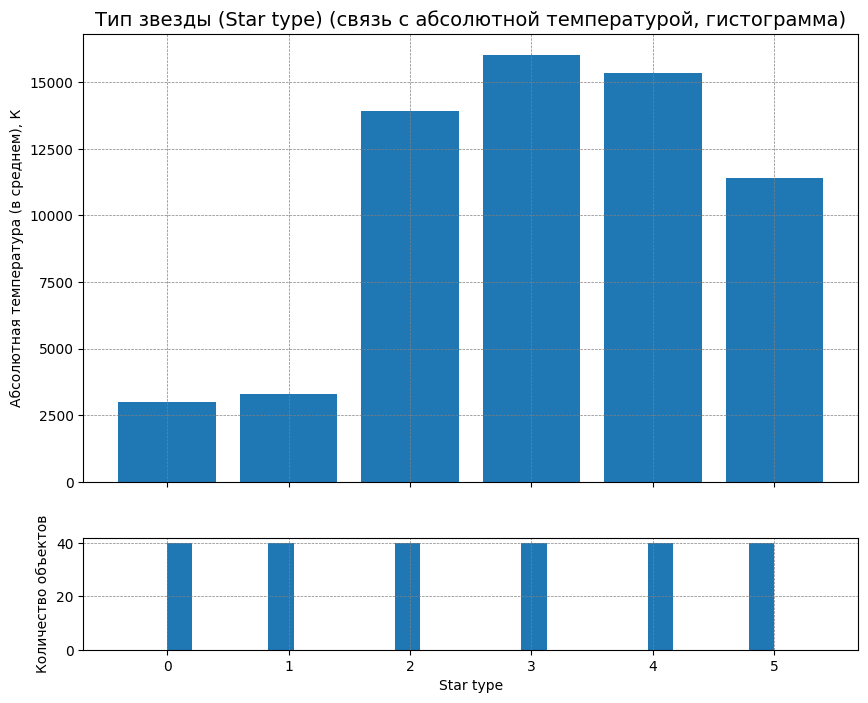

In [10]:
# Построим гистограмму по признаку Star type
# Также построим столбчатую диаграмму для визуализации связи абсолютной температуры и признака Star type
# Настроим внешний вид области построения
fig, ax = plt.subplots(ncols=1, nrows=2,
                       figsize=(10, 8),
                       sharex=True,
                       gridspec_kw={'height_ratios': (.8, .2)})
ax[0].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[0].set_title('Тип звезды (Star type) (связь с абсолютной температурой, гистограмма)', fontsize=14)
# Построим сами диаграммы
ax[0].set_yticks(range(0, 45000, 2500))
ax[0].set_ylabel('Абсолютная температура (в среднем), К')
type_data = df.groupby(['Star type'])['Temperature (K)'].agg('mean')
ax[0].bar(type_data.index, type_data)
ax[1].hist(df['Star type'], bins=24)
ax[1].set_xlabel('Star type')
ax[1].set_ylabel('Количество объектов')

plt.show()

По диаграмме можно сделать выводы:
- наиболее холодными и схожими по температуре являются коричневый карлик (тип 0) и красный карлик (тип 1),
- наиболее горячими являются звезды главной последовательности (тип 3), при этом температура в среднем близка к сверхгигантам (тип 4) и белым карликам (тип 2),
- несколько холоднее звёзд главной последовательности гипергиганты (тип 5).

In [11]:
# Изучим столбец с данными о типе звезды Star color
df['Star color'].value_counts()

Star color
Red                   112
Blue                   56
Blue-White             41
White                  10
Yellow-White            8
Yellowish-White         3
Yellowish               3
Whitish                 2
Orange                  2
Pale yellow orange      1
White-Yellow            1
Orange-Red              1
Name: count, dtype: int64

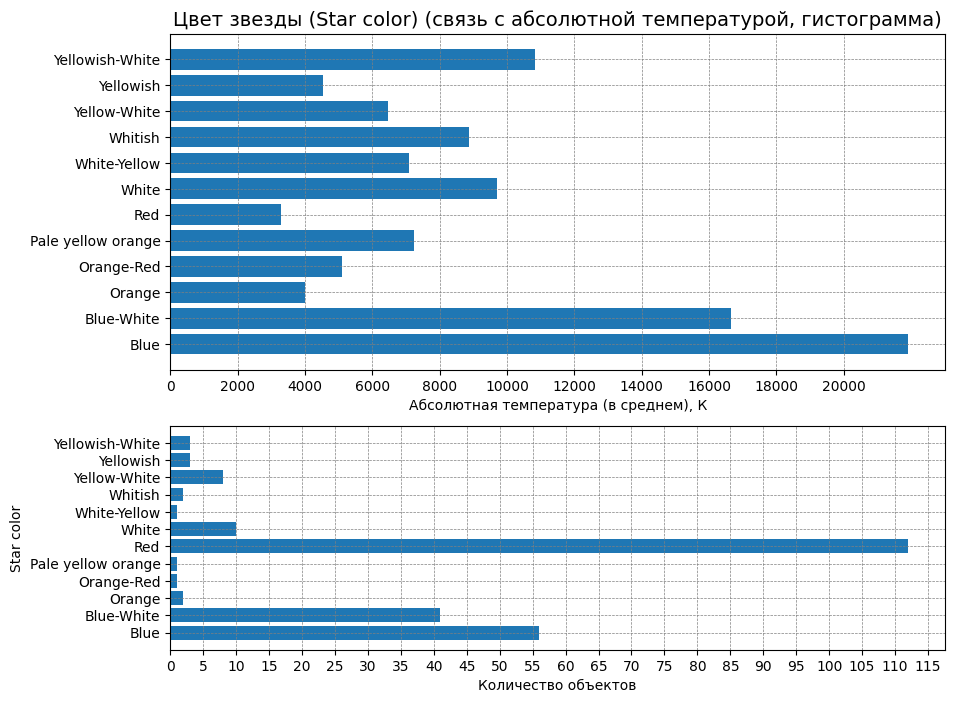

In [12]:
# Построим гистограмму по признаку Star color
# Также построим столбчатую диаграмму для визуализации связи абсолютной температуры и признака Star color
# Настроим внешний вид области построения
fig, ax = plt.subplots(ncols=1, nrows=2,
                       figsize=(10, 8),
                       gridspec_kw={'height_ratios': (.6, .4)})
ax[0].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[0].set_title('Цвет звезды (Star color) (связь с абсолютной температурой, гистограмма)', fontsize=14)
# Построим сами диаграммы
ax[0].set_xticks(range(0, 22000, 2000))
ax[0].set_xlabel('Абсолютная температура (в среднем), К')
color_data = df.groupby(['Star color'])['Temperature (K)'].agg(['count', 'mean'])
ax[0].barh(color_data.index, color_data['mean'])
ax[1].set_xticks(range(0, 120, 5))
ax[1].set_ylabel('Star color')
ax[1].set_xlabel('Количество объектов')
ax[1].barh(color_data.index, color_data['count'])
#ax[1].hist(df['Star color'], orientation='horizontal')
plt.show()

Некоторые категории представлены незначительным количеством объектов, при этом они схожи по цвету и значению температуры. Тем не менее, укрупнять категории не будем, чтоб не вносить погрешность в данные.

####  Относительная светимость Luminosity(L/Lo)

In [13]:
# Изучим столбец с данными об относительной светимости Luminosity(L/Lo)
df['Luminosity(L/Lo)'].describe()

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: Luminosity(L/Lo), dtype: float64

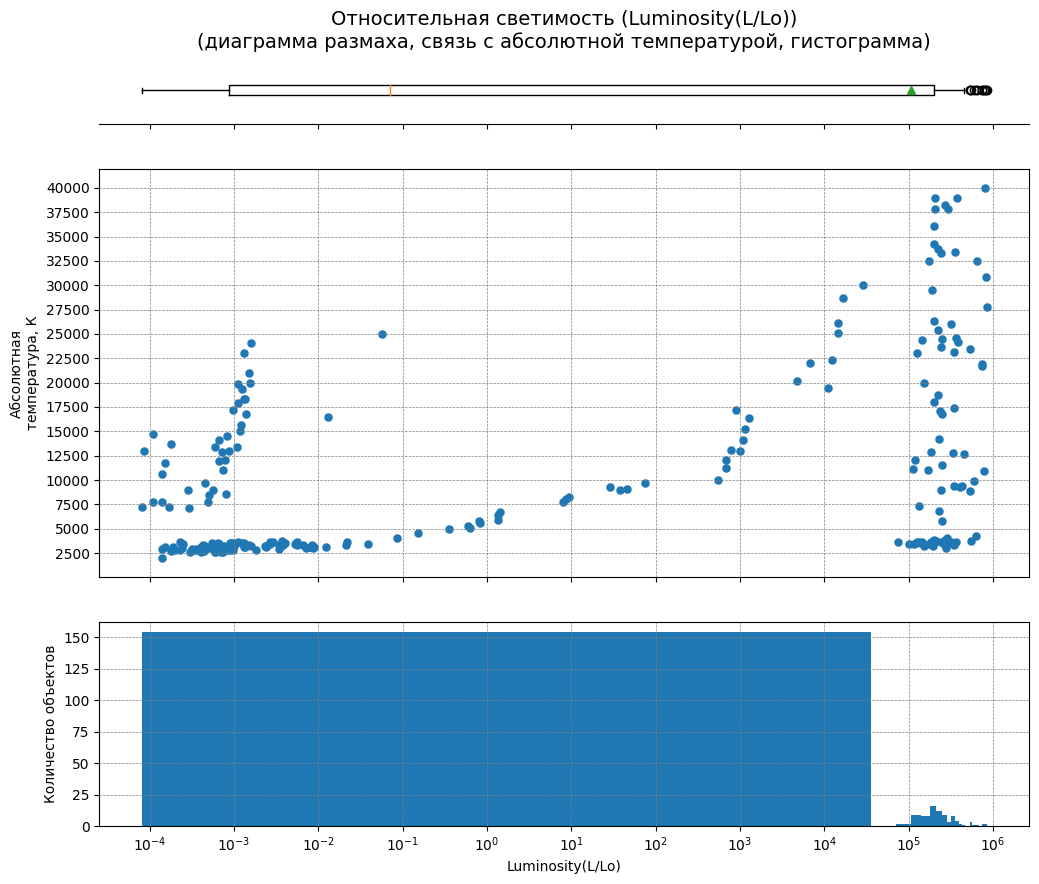

In [14]:
# Построим диаграмму размаха (boxplot) и гистограмму по признаку Luminosity(L/Lo)
# Также построим диграмму рассеяния для визуализации связи абсолютной температуры и признака Luminosity(L/Lo)
# Настроим внешний вид области построения
fig, ax = plt.subplots(ncols=1, nrows=3,
                       figsize=(12, 10),
                       sharex=True,
                       gridspec_kw={'height_ratios': (.1, .6, .3)})
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].tick_params(axis='y', left=False, labelleft=False)
ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[2].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[0].set_title('Относительная светимость (Luminosity(L/Lo))\n(диаграмма размаха, \
связь с абсолютной температурой, гистограмма)', fontsize=14)
# Построим сами диаграммы
ax[0].boxplot(df['Luminosity(L/Lo)'], vert=False, showmeans=True)
ax[1].set_yticks(range(0, 45000, 2500))
ax[1].set_ylabel('Абсолютная\nтемпература, К')
ax[1].scatter(df['Luminosity(L/Lo)'], df['Temperature (K)'], linewidths=0.1)
ax[2].hist(df['Luminosity(L/Lo)'], bins=24)
ax[2].set_xlabel('Luminosity(L/Lo)')
ax[2].set_ylabel('Количество объектов')
ax[2].set_xscale('log')
ax[2].set_xticks(np.logspace(-4, 6, 11))

plt.show()

По диаграмме рассеяния видно, что все объекты можно отнести к трём категориям:
- звёзды с температурой выше 6000 К и светимостью ниже 1,
- звёзды с температурой ниже 30000 К и светимостью выше 70000, либо с температурой ниже 35000 К и светимостью выше 500000
- остальные звёзды.

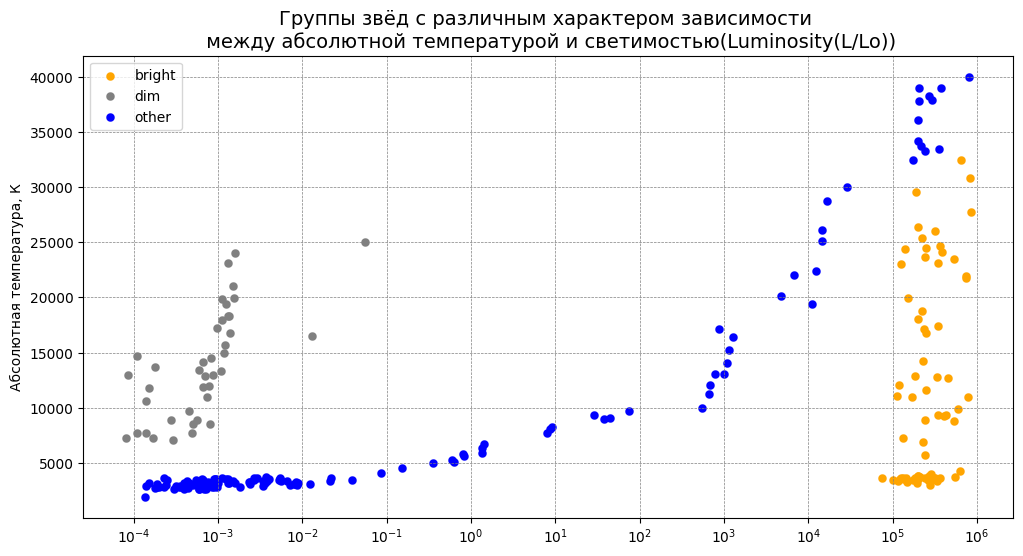

In [15]:
# Построим диаграмму рассеяния для визуализации описанных выше групп
plt.figure(figsize=(12,6))
plt.grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
plt.title('Группы звёд с различным характером зависимости \n между абсолютной температурой и светимостью\
(Luminosity(L/Lo))', fontsize=14)
plt.yticks(range(0, 45000, 5000))
plt.ylabel('Абсолютная температура, К')
# Звёзды с температурой ниже 30000 К и светимостью выше 70000,
# либо с температурой ниже 35000 К и светимостью выше 500000
bright_stars_indexes = df[((df['Temperature (K)']<30000)&(df['Luminosity(L/Lo)']>70000))|
                          ((df['Temperature (K)']<35000)&(df['Luminosity(L/Lo)']>500000))].index
plt.scatter(df.loc[bright_stars_indexes, 'Luminosity(L/Lo)'],
            df.loc[bright_stars_indexes, 'Temperature (K)'],
            linewidths=0.1, color='orange', label='bright')

# Звёзды с температурой выше 6000 К и светимостью ниже 1
dim_stars_indexes = df[(df['Temperature (K)']>6000)&(df['Luminosity(L/Lo)']<1)].index

plt.scatter(df.loc[dim_stars_indexes, 'Luminosity(L/Lo)'],
            df.loc[dim_stars_indexes, 'Temperature (K)'],
            linewidths=0.1, color='grey', label='dim')

# Звёзды, которые не попали в первые две группы
plt.scatter(df[~(df.index.isin(bright_stars_indexes)|df.index.isin(dim_stars_indexes))]['Luminosity(L/Lo)'],
            df[~(df.index.isin(bright_stars_indexes)|df.index.isin(dim_stars_indexes))]['Temperature (K)'],
            linewidths=0.1, color='blue', label='other')
plt.xscale('log')
plt.xticks(np.logspace(-4, 6, 11))
plt.legend()
plt.show()

In [16]:
# Добавим ещё один признак для дальнейшего использования: brightness_cat, - со значениями 'bright', 'dim', 'other'
df.loc[bright_stars_indexes, 'brightness_cat'] = 'bright'
df.loc[dim_stars_indexes, 'brightness_cat'] = 'dim'
df.loc[~(df.index.isin(bright_stars_indexes)|df.index.isin(dim_stars_indexes)), 'brightness_cat'] = 'other'
df['brightness_cat'].value_counts()

brightness_cat
other     126
bright     74
dim        40
Name: count, dtype: int64

####  Относительный радиус Radius(R/Ro)

In [17]:
# Изучим столбец с данными об относительной светимости Luminosity(L/Lo)
df['Radius(R/Ro)'].describe()

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: Radius(R/Ro), dtype: float64

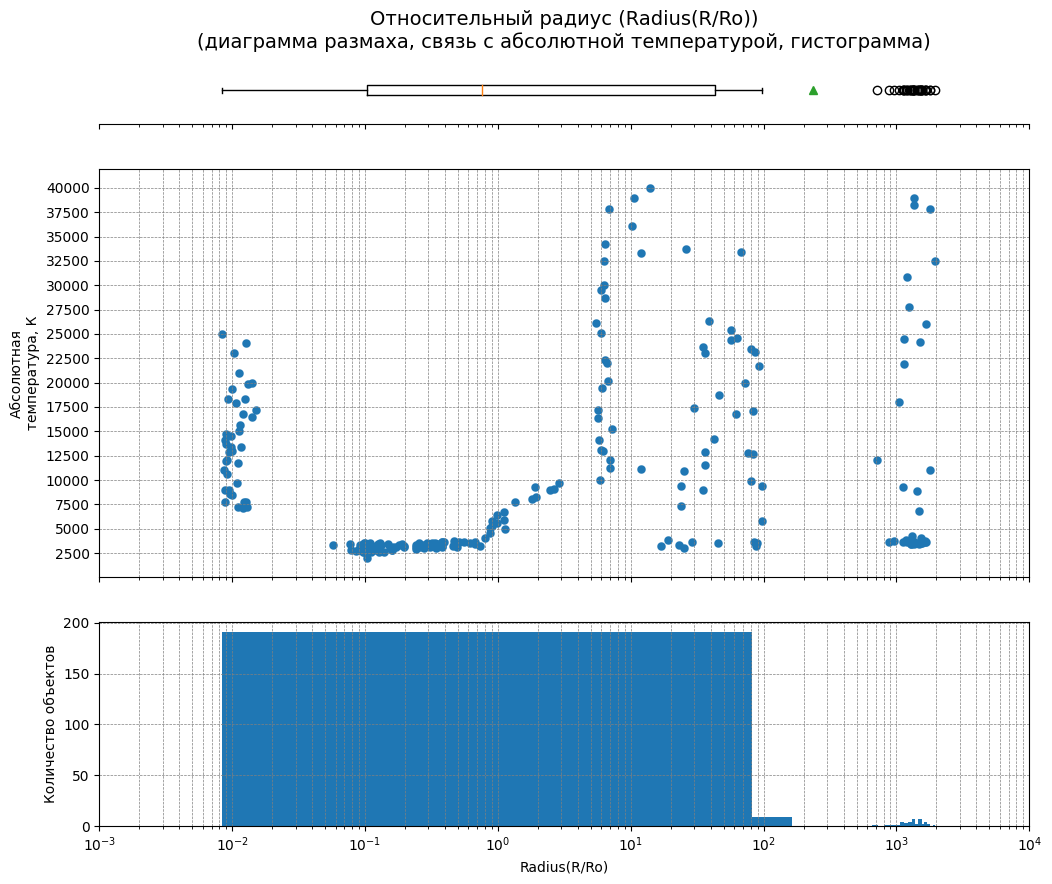

In [18]:
# Построим диаграмму размаха (boxplot) и гистограмму по признаку Radius(R/Ro)
# Также построим диграмму рассеяния для визуализации связи абсолютной температуры и признака Radius(R/Ro)
# Настроим внешний вид области построения
fig, ax = plt.subplots(ncols=1, nrows=3,
                       figsize=(12, 10),
                       sharex=True,
                       gridspec_kw={'height_ratios': (.1, .6, .3)})
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].tick_params(axis='y', left=False, labelleft=False)
ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[2].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[0].set_title('Относительный радиус (Radius(R/Ro))\n(диаграмма размаха, \
связь с абсолютной температурой, гистограмма)', fontsize=14)
# Построим сами диаграммы
ax[0].boxplot(df['Radius(R/Ro)'], vert=False, showmeans=True)
ax[1].set_yticks(range(0, 45000, 2500))
ax[1].set_ylabel('Абсолютная\nтемпература, К')
ax[1].scatter(df['Radius(R/Ro)'], df['Temperature (K)'], linewidths=0.1)
ax[2].hist(df['Radius(R/Ro)'], bins=24)
ax[2].set_xlabel('Radius(R/Ro)')
ax[2].set_ylabel('Количество объектов')
ax[2].set_xscale('log')
ax[2].set_xticks(np.logspace(-3, 4, 8))

plt.show()

По диаграмме рассеяния видно, что все объекты можно отнести к четырём категориям:
- звёзды с относительным радиусом меньше 0,02,
- звёзды с относительным радиусом больше 500,
- звёзды с относительным радиусом больше 10 и меньше 100, с температурой ниже 35000 К,
- остальные звёзды.

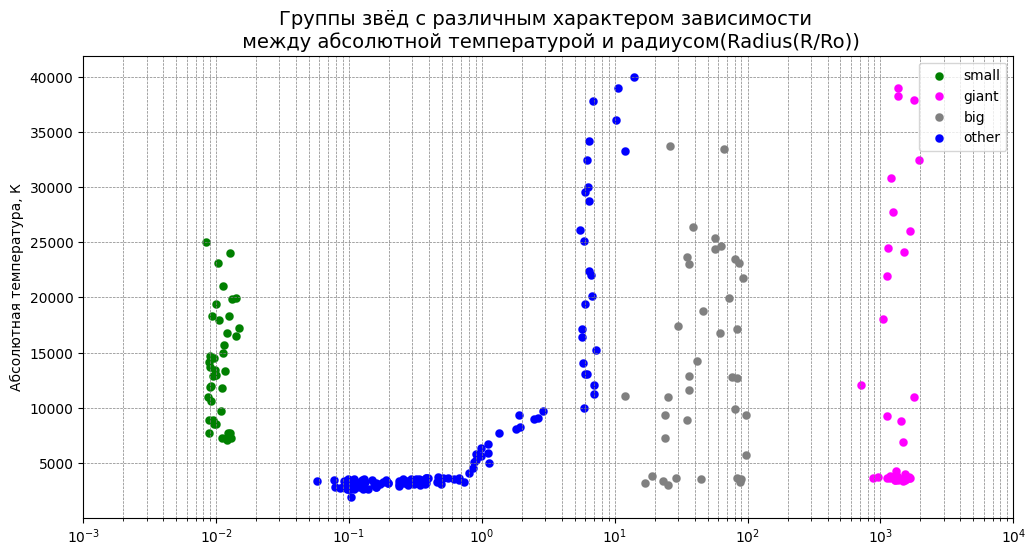

In [19]:
# Построим диаграмму рассеяния для визуализации описанных выше групп
plt.figure(figsize=(12,6))
plt.grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
plt.title('Группы звёд с различным характером зависимости \n между абсолютной температурой и радиусом\
(Radius(R/Ro))', fontsize=14)
plt.yticks(range(0, 45000, 5000))
plt.ylabel('Абсолютная температура, К')
# Звёзды с относительным радиусом меньше 0,02
small_stars_indexes = df[df['Radius(R/Ro)']<0.02].index
plt.scatter(df.loc[small_stars_indexes, 'Radius(R/Ro)'],
            df.loc[small_stars_indexes, 'Temperature (K)'],
            linewidths=0.1, color='green', label='small')

# Звёзды с относительным радиусом больше 500
giant_stars_indexes = df[df['Radius(R/Ro)']>500].index
plt.scatter(df.loc[giant_stars_indexes, 'Radius(R/Ro)'],
            df.loc[giant_stars_indexes, 'Temperature (K)'],
            linewidths=0.1, color='magenta', label='giant')

# Звёзды с относительным радиусом больше 10 и меньше 100, с температурой ниже 30000 К
# либо с относительным радиусом больше 20 и меньше 100, с температурой ниже 35000 К
big_stars_indexes = df[((df['Temperature (K)']<30000)&(df['Radius(R/Ro)']>10)&(df['Radius(R/Ro)']<100))|
                       ((df['Temperature (K)']<35000)&(df['Radius(R/Ro)']>20)&(df['Radius(R/Ro)']<100))].index
plt.scatter(df.loc[big_stars_indexes, 'Radius(R/Ro)'],
            df.loc[big_stars_indexes, 'Temperature (K)'],
            linewidths=0.1, color='grey', label='big')

# Звёзды, которые не попали в первые три группы
plt.scatter(df[~(df.index.isin(small_stars_indexes)|
                 df.index.isin(giant_stars_indexes)|
                 df.index.isin(big_stars_indexes))]['Radius(R/Ro)'],
            df[~(df.index.isin(small_stars_indexes)|
                 df.index.isin(giant_stars_indexes)|
                 df.index.isin(big_stars_indexes))]['Temperature (K)'],
            linewidths=0.1, color='blue', label='other')
plt.xscale('log')
plt.xticks(np.logspace(-3, 4, 8))
plt.legend()
plt.show()

In [20]:
# Добавим ещё один признак для дальнейшего использования: radius_cat, - со значениями 'small', 'giant', 'big', other'
df.loc[small_stars_indexes, 'radius_cat'] = 'small'
df.loc[giant_stars_indexes, 'radius_cat'] = 'giant'
df.loc[big_stars_indexes, 'radius_cat'] = 'big'
df.loc[~(df.index.isin(small_stars_indexes)|df.index.isin(giant_stars_indexes)|
         df.index.isin(big_stars_indexes)), 'radius_cat'] = 'other'
df['radius_cat'].value_counts()

radius_cat
other    122
small     40
giant     40
big       38
Name: count, dtype: int64

####  Абсолютная звёздная величина Absolute magnitude(Mv)

In [21]:
# Изучим столбец с данными об относительной светимости Luminosity(L/Lo)
df['Absolute magnitude(Mv)'].describe()

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: Absolute magnitude(Mv), dtype: float64

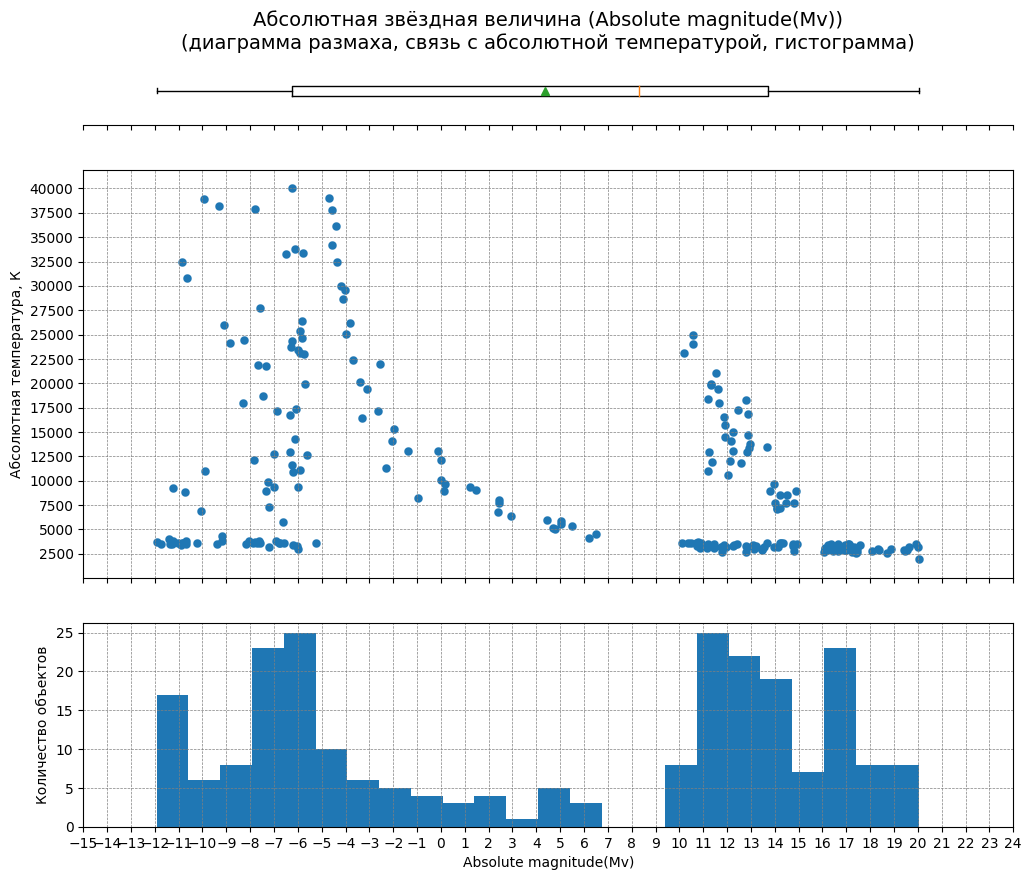

In [22]:
# Построим диаграмму размаха (boxplot) и гистограмму по признаку Radius(R/Ro)
# Также построим диграмму рассеяния для визуализации связи абсолютной температуры и признака Radius(R/Ro)
# Настроим внешний вид области построения
fig, ax = plt.subplots(ncols=1, nrows=3,
                       figsize=(12, 10),
                       sharex=True,
                       gridspec_kw={'height_ratios': (.1, .6, .3)})
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].tick_params(axis='y', left=False, labelleft=False)
ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[2].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[0].set_title('Абсолютная звёздная величина (Absolute magnitude(Mv))\n(диаграмма размаха, \
связь с абсолютной температурой, гистограмма)', fontsize=14)
# Построим сами диаграммы
ax[0].boxplot(df['Absolute magnitude(Mv)'], vert=False, showmeans=True)
ax[1].set_yticks(range(0, 45000, 2500))
ax[1].set_ylabel('Абсолютная температура, К')
ax[1].scatter(df['Absolute magnitude(Mv)'], df['Temperature (K)'], linewidths=0.1)
ax[2].hist(df['Absolute magnitude(Mv)'], bins=24)
ax[2].set_xlabel('Absolute magnitude(Mv)')
ax[2].set_ylabel('Количество объектов')
ax[2].set_xticks(np.arange(-15, 25, 1))

plt.show()

По диаграмме рассеяния видно, что все объекты можно отнести к четырём категориям:
- звёзды с абсолютной звёздной величиной больше 9 и абсолютной температурой больше 6000 К,
- звёзды с абсолютной звёздной величиной меньше -7,5 и абсолютной температурой меньше 12500 К,
- звёзды с абсолютной звёздной величиной от -7,5 до -4 и абсолютной температурой меньше 5000 К, или с абсолютной звёздной величиной от -9 до -4.5 и абсолютной температурой от 5000 К и меньше 15000 К, или с абсолютной звёздной величиной от -9 до -5 и абсолютной температурой от 15000 К и меньше 22500 К, или с абсолютной звёздной величиной меньше -5 и абсолютной температурой от 22500 К и меньше 30000 К, или с абсолютной звёздной величиной меньше -9 и абсолютной температурой от 30000 К и меньше 35000 К,
- остальные звёзды.

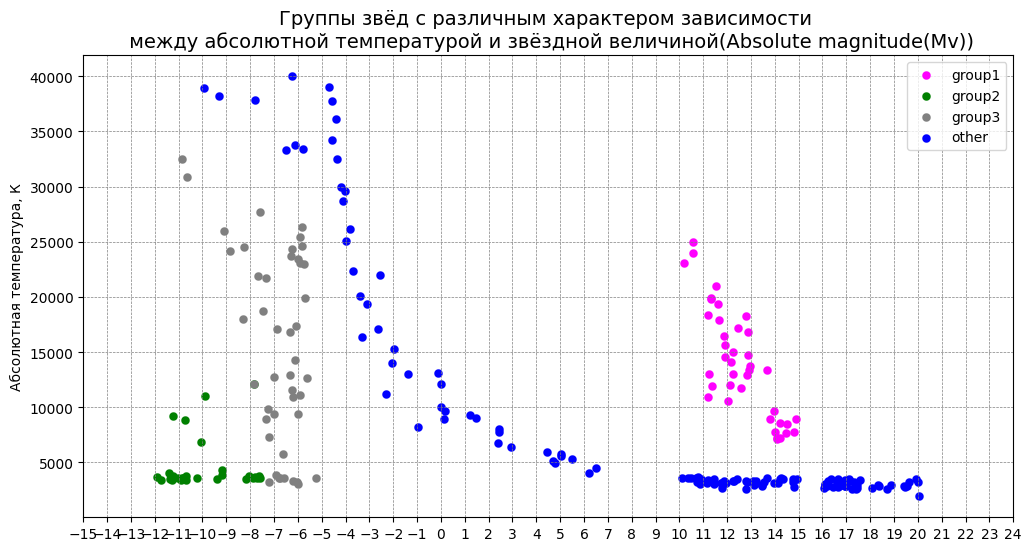

In [23]:
# Построим диаграмму рассеяния для визуализации описанных выше групп
plt.figure(figsize=(12,6))
plt.grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
plt.title('Группы звёд с различным характером зависимости \n между абсолютной температурой и звёздной величиной\
(Absolute magnitude(Mv))', fontsize=14)
plt.yticks(range(0, 45000, 5000))
plt.ylabel('Абсолютная температура, К')
# Звёзды с абсолютной звёздной величиной больше 9 и абсолютной температурой больше 6000 К
group1_stars_indexes = df[(df['Absolute magnitude(Mv)']>9)&(df['Temperature (K)']>6000)].index
plt.scatter(df.loc[group1_stars_indexes, 'Absolute magnitude(Mv)'],
            df.loc[group1_stars_indexes, 'Temperature (K)'],
            linewidths=0.1, color='magenta', label='group1')

# Звёзды с абсолютной звёздной величиной меньше -7,5 и абсолютной температурой меньше 12500 К,
group2_stars_indexes = df[(df['Absolute magnitude(Mv)']<-7.5)&(df['Temperature (K)']<12500)].index
plt.scatter(df.loc[group2_stars_indexes, 'Absolute magnitude(Mv)'],
            df.loc[group2_stars_indexes, 'Temperature (K)'],
            linewidths=0.1, color='green', label='group2')

# звёзды с абсолютной звёздной величиной от -7,5 до -4 и абсолютной температурой меньше 5000 К,
# или с абсолютной звёздной величиной от -9 до -4.5 и абсолютной температурой от 5000 К и меньше 15000 К,
# или с абсолютной звёздной величиной от -9 до -5 и абсолютной температурой от 15000 К и меньше 22500 К,
# или с абсолютной звёздной величиной меньше -5 и абсолютной температурой от 22500 К и меньше 30000 К,
# или с абсолютной звёздной величиной меньше -9 и абсолютной температурой от 30000 К и меньше 35000 К
group3_stars_indexes = \
df[((df['Temperature (K)']<5000)&(df['Absolute magnitude(Mv)']>-7.5)&(df['Absolute magnitude(Mv)']<-4))|
   ((df['Temperature (K)']>=5000)&(df['Temperature (K)']<15000)&
    (df['Absolute magnitude(Mv)']>-9)&(df['Absolute magnitude(Mv)']<-4.5))|
   ((df['Temperature (K)']>=15000)&(df['Temperature (K)']<22500)&
    (df['Absolute magnitude(Mv)']>-9)&(df['Absolute magnitude(Mv)']<-5))|
   ((df['Temperature (K)']>=22500)&(df['Temperature (K)']<30000)&(df['Absolute magnitude(Mv)']<-5))|
   ((df['Temperature (K)']>=30000)&(df['Temperature (K)']<35000)&(df['Absolute magnitude(Mv)']<-9))].index
plt.scatter(df.loc[group3_stars_indexes, 'Absolute magnitude(Mv)'],
            df.loc[group3_stars_indexes, 'Temperature (K)'],
            linewidths=0.1, color='grey', label='group3')

# Звёзды, которые не попали в первые три группы
plt.scatter(df[~(df.index.isin(group1_stars_indexes)|
                 df.index.isin(group2_stars_indexes)|
                 df.index.isin(group3_stars_indexes))]['Absolute magnitude(Mv)'],
            df[~(df.index.isin(group1_stars_indexes)|
                 df.index.isin(group2_stars_indexes)|
                 df.index.isin(group3_stars_indexes))]['Temperature (K)'],
            linewidths=0.1, color='blue', label='other')
plt.xticks(np.arange(-15, 25, 1))
plt.legend()
plt.show()

In [24]:
# Добавим ещё один признак для дальнейшего использования: magnitude_cat, - со значениями 'cat_1', 'cat_2', 'cat_3', other'
df.loc[group1_stars_indexes, 'magnitude_cat'] = 'cat_1'
df.loc[group2_stars_indexes, 'magnitude_cat'] = 'cat_2'
df.loc[group3_stars_indexes, 'magnitude_cat'] = 'cat_3'
df.loc[~(df.index.isin(group1_stars_indexes)|df.index.isin(group2_stars_indexes)|
         df.index.isin(group3_stars_indexes)), 'magnitude_cat'] = 'other'
df['magnitude_cat'].value_counts()

magnitude_cat
other    127
cat_3     45
cat_1     40
cat_2     28
Name: count, dtype: int64

####  Абсолютная температура (целевой признак)

In [25]:
# Проанализируем целевой признак
df['Temperature (K)'].describe()

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: Temperature (K), dtype: float64

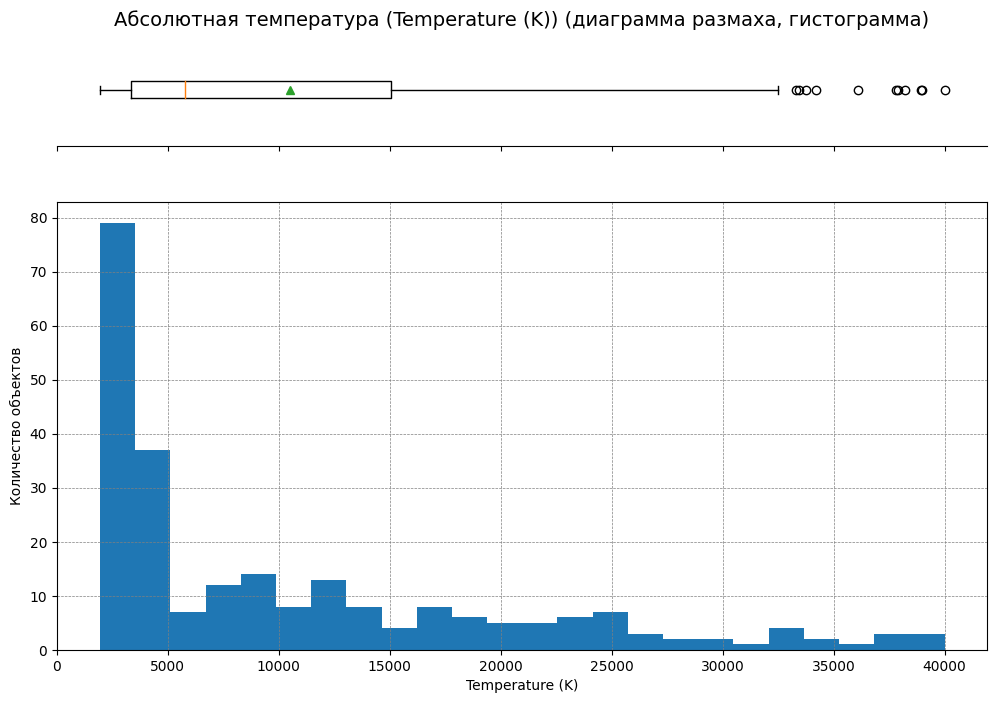

In [26]:
# Построим диаграмму размаха (boxplot) и гистограмму по целевому признаку Radius(R/Ro)
# Настроим внешний вид области построения
fig, ax = plt.subplots(ncols=1, nrows=2,
                       figsize=(12, 8),
                       sharex=True,
                       gridspec_kw={'height_ratios': (.2, .8)})
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)
ax[0].tick_params(axis='y', left=False, labelleft=False)
ax[1].grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
ax[0].set_title('Абсолютная температура (Temperature (K)) (диаграмма размаха, гистограмма)', fontsize=14)
# Построим сами диаграммы
ax[0].boxplot(df['Temperature (K)'], vert=False, showmeans=True)
ax[1].hist(df['Temperature (K)'], bins=24)
ax[1].set_xlabel('Temperature (K)')
ax[1].set_ylabel('Количество объектов')
ax[1].set_xticks(range(0, 45000, 5000))

plt.show()

Звёзд с температурой более 5000 К приблизительно половина выборки, однако диапазон температур от 5000 К до 40000 К, т.е. половина выборки имеет температуру 3000-5000 К. Каких-либо аномалий не наблюдается.

### Подготовка данных для модели

#### Финальный выбор признаков

In [27]:
# Преобразуем значения признака `Star type` в категории
types = {0:'Коричневый карлик',
         1:'Красный карлик',
         2:'Белый карлик',
         3:'Звёзды главной последовательности',
         4:'Сверхгигант',
         5:'Гипергигант'
}
for type_number in df['Star type'].unique():
    df.loc[df['Star type']==type_number, 'Star type_cat'] = types[type_number]
df['Star type_cat'].value_counts()

Star type_cat
Коричневый карлик                    40
Красный карлик                       40
Белый карлик                         40
Звёзды главной последовательности    40
Сверхгигант                          40
Гипергигант                          40
Name: count, dtype: int64

In [28]:
# Уберём исходный столбец с признаком Star type
df = df.drop(['Star type'], axis=1)

In [29]:
# Разделим выборки на обучающую и тестовую
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
train_index = train.index
test_index = test.index
print('Обучающая выборка: ', train.shape[0], ', ',  round(train.shape[0]/df.shape[0], 2), sep='')
print('Тестовая выборка: ', test.shape[0], ', ', round(test.shape[0]/df.shape[0], 2), sep='')

Обучающая выборка: 192, 0.8
Тестовая выборка: 48, 0.2


In [30]:
train.columns

Index(['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)',
       'Absolute magnitude(Mv)', 'Star color', 'brightness_cat', 'radius_cat',
       'magnitude_cat', 'Star type_cat'],
      dtype='object')

In [31]:
# Разделим признаки
X = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)', 'Star type_cat', 'Star color', 'brightness_cat',
     'radius_cat', 'magnitude_cat']
y = ['Temperature (K)']

In [32]:
# Составим список категориальных признаков
cat_features = train[X].select_dtypes(include='object').columns.to_list()
cat_features

['Star type_cat',
 'Star color',
 'brightness_cat',
 'radius_cat',
 'magnitude_cat']

In [33]:
# Составим список числовых признаков
numeric = train[X].select_dtypes(include=['int64', 'float64']).columns.to_list()
numeric

['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

#### Кодирование категориальных признаков

In [34]:
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(train[cat_features])

# добавляем закодированные признаки в train
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train_ohe_scaled = train[X].copy()
transformed_features = pd.DataFrame(encoder_ohe.transform(features_train_ohe_scaled[cat_features]),
                                    columns = encoder_ohe.get_feature_names_out(),
                                    index=train.index)
features_train_ohe_scaled = pd.concat([features_train_ohe_scaled, transformed_features], axis=1)

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_ohe_scaled = features_train_ohe_scaled.drop(cat_features, axis=1)

# Аналогичные преобразования с подготовленным на обучающей выборке энкодером выполним для тестовой выборки
features_test_ohe_scaled = test[X].copy()
transformed_features = pd.DataFrame(encoder_ohe.transform(features_test_ohe_scaled[cat_features]),
                                    columns = encoder_ohe.get_feature_names_out(),
                                    index=test.index)
features_test_ohe_scaled = pd.concat([features_test_ohe_scaled, transformed_features], axis=1)
features_test_ohe_scaled = features_test_ohe_scaled.drop(cat_features, axis=1)

# Проверим результаты
print('features_train_ohe_scaled', features_train_ohe_scaled.shape)
print('features_test_ohe_scaled', features_test_ohe_scaled.shape)

features_train_ohe_scaled (192, 27)
features_test_ohe_scaled (48, 27)


#### Масштабирование числовых признаков

In [35]:
# Выполним масштабирование числовых признаков
scaler = StandardScaler()
scaler.fit(train[numeric])
features_train_ohe_scaled[numeric] = scaler.transform(features_train_ohe_scaled[numeric])

# C подготовленным на обучающей выборке скалером выполним масштабирование признаков тестовой выборки
features_test_ohe_scaled[numeric] = scaler.transform(features_test_ohe_scaled[numeric])

In [36]:
# Посмотрим первые строки выборок после преобразований
display (features_train_ohe_scaled.head(3))
display (features_test_ohe_scaled.head(3))

,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type_cat_Гипергигант,Star type_cat_Звёзды главной последовательности,Star type_cat_Коричневый карлик,Star type_cat_Красный карлик,Star type_cat_Сверхгигант,Star color_Blue-White,Star color_Orange,...,Star color_Yellowish,Star color_Yellowish-White,brightness_cat_dim,brightness_cat_other,radius_cat_giant,radius_cat_other,radius_cat_small,magnitude_cat_cat_2,magnitude_cat_cat_3,magnitude_cat_other
139,-0.573535,-0.425464,0.869405,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
14,-0.573535,-0.425707,0.626075,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
67,-0.573535,-0.425810,1.071862,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


,Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type_cat_Гипергигант,Star type_cat_Звёзды главной последовательности,Star type_cat_Коричневый карлик,Star type_cat_Красный карлик,Star type_cat_Сверхгигант,Star color_Blue-White,Star color_Orange,...,Star color_Yellowish,Star color_Yellowish-White,brightness_cat_dim,brightness_cat_other,radius_cat_giant,radius_cat_other,radius_cat_small,magnitude_cat_cat_2,magnitude_cat_cat_3,magnitude_cat_other
232,3.209459,3.668232,-1.534292,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
30,0.616618,-0.403729,-0.947932,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
216,-0.573366,-0.421988,-0.381052,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [40]:
# Преобразуем данные в тензоры
X_train = torch.FloatTensor(features_train_ohe_scaled.values).to(device)
X_test = torch.FloatTensor(features_test_ohe_scaled.values).to(device)
y_train = torch.FloatTensor(train[y].values).flatten().to(device)
y_test = torch.FloatTensor(test[y].values).flatten().to(device)

Выводы по предобработке и анализу данных:
- устранены неявные дубликаты,
- проанализированы признаки, добавлены дополнительные признаки,
- исходная выборка разделена на обучающую и тестовую,
- категориальные признаки закодированы,
- чиловые признаки отмасштабированы.

Данные для моделей подготовлены.

## Построение базовой нейронной сети

В качестве базовой модели возьмём нейронную сеть с одним скрытым слоем.

Параметры сети:
- количество нейрнов во входном слое - 27 (по числу признаков),
- количество нейронов в выходном слое - 1,
- количество нейронов в скрытом слое будем перебирать от $\sqrt{27*1} \approx 5$ (примем 8) до $27*(2/3)=18$ (примем 16) по степеням двойки 8, 16, а также добавим вариант 32,
- функция активации скрытого и выходного слоёв - ReLU,
- инициализация весов модели - по умолчанию,
- функция потерь - mean squared error, MSE,
- метрика - root mean squared error, RMSE.

In [45]:
# Создадим класс для задания архитектуры нейронной сети
class Net_1(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons, n_out_neurons):
        super(Net_1, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons, n_out_neurons)
        self.act2 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        return x

In [46]:
# Создадим функцию для обучения нейронной сети
def train_net(
    net, X_train, y_train, X_val, y_val, num_epochs, batch_size, learning_rate
):
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    loss = nn.MSELoss()
    num_batches = int(np.ceil(len(X_train) / batch_size))
    best_result = max(y_val)
    for epoch in range(num_epochs):
        order = np.random.permutation(
            len(X_train)
        )  # создадим случайную перестановку индексов объектов
        for batch_idx in range(num_batches):
            start_index = (
                batch_idx * batch_size
            )  # посчитаем номер стартового объекта батча
            optimizer.zero_grad()
  
            batch_indexes = order[
                start_index : start_index + batch_size
            ]  # извлечём индексы объектов текущего обатча
            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)
            preds = net.forward(X_train).flatten().to(device)
            loss_value = loss(preds, y_train)
            loss_value.backward()
            optimizer.step()
        if epoch % 1000 == 0 or epoch + 1 == num_epochs:
            net.eval()
            val_preds = net.forward(X_val).flatten().to(device)
            rmse = round(loss(val_preds, y_val).item()**0.5)
            print(f'эпоха {epoch}, rmse: {rmse: .1f}, best_rmse: {best_result: .1f}')
            if rmse < 0.999*best_result:
                best_result = rmse
                best_params = net.named_parameters()
            else:
                for name, param in best_params:
                    if name == 'fc1.weight':
                        net.fc1.weight = param
                    elif name == 'fc1.bias':
                        net.fc1.bias = param
                    if name == 'bn1.weight':
                        net.bn1.weight = param
                    elif name == 'bn1.bias':
                        net.bn1.bias = param       
                    if name == 'fc2.weight':
                        net.fc2.weight = param
                    elif name == 'fc2.bias':
                        net.fc2.bias = param
                    if name == 'bn2.weight':
                        net.bn2.weight = param
                    elif name == 'bn2.bias':
                        net.bn2.bias = param       
                    if name == 'fc3.weight':
                        net.fc3.weight = param
                    elif name == 'fc3.bias':
                        net.fc3.bias = param
                    if name == 'bn3.weight':
                        net.bn3.weight = param
                    elif name == 'bn3.bias':
                        net.bn3.bias = param       
                    if name == 'fc4.weight':
                        net.fc4.weight = param
                    elif name == 'fc4.bias':
                        net.fc4.bias = param                
                net.eval()
                print(
                    f'Обучение закончилось с лучшим результатом (rmse): {best_result: .1f}'
                )
                return net            
            net.train()
    net.eval()
    return net

In [49]:
# Перебором количества нейронов в скрытом слое найдём модель с лучшим значением метрики
num_epochs = 15000
batch_size = 48
learning_rate = 2.0e-3
for n_hid in [8, 16, 32]:
    print('Hidden neurones', n_hid)
    net = Net_1(27, n_hid, 1).to(device)
    net = train_net(net, X_train, y_train, X_test, y_test, num_epochs, batch_size, learning_rate)
    print()

Hidden neurones 8
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  12852.0, best_rmse:  16084.0
эпоха 2000, rmse:  8808.0, best_rmse:  12852.0
эпоха 3000, rmse:  7440.0, best_rmse:  8808.0
эпоха 4000, rmse:  6617.0, best_rmse:  7440.0
эпоха 5000, rmse:  6108.0, best_rmse:  6617.0
эпоха 6000, rmse:  5685.0, best_rmse:  6108.0
эпоха 7000, rmse:  5292.0, best_rmse:  5685.0
эпоха 8000, rmse:  5014.0, best_rmse:  5292.0
эпоха 9000, rmse:  4967.0, best_rmse:  5014.0
эпоха 10000, rmse:  4922.0, best_rmse:  4967.0
эпоха 11000, rmse:  4875.0, best_rmse:  4922.0
эпоха 12000, rmse:  4824.0, best_rmse:  4875.0
эпоха 13000, rmse:  4769.0, best_rmse:  4824.0
эпоха 14000, rmse:  4710.0, best_rmse:  4769.0
эпоха 14999, rmse:  4648.0, best_rmse:  4710.0

Hidden neurones 16
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  11570.0, best_rmse:  16084.0
эпоха 2000, rmse:  7806.0, best_rmse:  11570.0
эпоха 3000, rmse:  6818.0, best_rmse:  7806.0
эпоха 4000, rmse:  6103.0, best_

Учтывая значения целевого признака от 2000 до 40000, лучшее достигнутое базовой моделью значение метрики приблизительно 4074 К при 32 нейронах в скрытом слое недостаточно низкое значение ошибки. Попробуем увеличить количество слоёв.

In [50]:
# Создадим класс для задания архитектуры нейронной сети
class Net_2(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net_2, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)

        return x

In [51]:
# Перебором количества нейронов в скрытых слоях найдём модель с лучшим значением метрики
num_epochs = 15000
batch_size = 48
learning_rate = 2.0e-3
for n_hid_1 in [8, 16, 32]:
    for n_hid_2 in [8, 16, 32]:
        net = Net_2(27, n_hid_1, n_hid_2, 1).to(device)
        print('Hidden neurones: n_hid_1', n_hid_1, 'n_hid_2', n_hid_2)
        net = train_net(net, X_train, y_train, X_test, y_test, num_epochs, batch_size, learning_rate)
        print('end of variant')
        print()

Hidden neurones: n_hid_1 8 n_hid_2 8
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  6147.0, best_rmse:  16084.0
эпоха 2000, rmse:  4951.0, best_rmse:  6147.0
эпоха 3000, rmse:  4530.0, best_rmse:  4951.0
эпоха 4000, rmse:  4219.0, best_rmse:  4530.0
эпоха 5000, rmse:  4222.0, best_rmse:  4219.0
Обучение закончилось с лучшим результатом (rmse):  4219.0
end of variant

Hidden neurones: n_hid_1 8 n_hid_2 16
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  5609.0, best_rmse:  16084.0
эпоха 2000, rmse:  4688.0, best_rmse:  5609.0
эпоха 3000, rmse:  4095.0, best_rmse:  4688.0
эпоха 4000, rmse:  4269.0, best_rmse:  4095.0
Обучение закончилось с лучшим результатом (rmse):  4095.0
end of variant

Hidden neurones: n_hid_1 8 n_hid_2 32
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  16084.0, best_rmse:  16084.0
Обучение закончилось с лучшим результатом (rmse):  16084.0
end of variant

Hidden neurones: n_hid_1 16 n_hid_2 8
эпоха 0, rmse:  16084.0, be

Результат удалось улучшить. Наилучший результат RMSE=3743 К получен сетью с двумя скрытыми слоями: 16 и 8 нейронов в первом и втором скрытом слое соответственно. Возьмём за базовый вариант именно такую модель.

In [53]:
num_epochs = 15000
batch_size = 48
learning_rate = 1.0e-3
base_net = Net_2(27, 16, 8, 1).to(device)
base_net = train_net(base_net, X_train, y_train, X_test, y_test, num_epochs, batch_size, learning_rate)

эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  6959.0, best_rmse:  16084.0
эпоха 2000, rmse:  5396.0, best_rmse:  6959.0
эпоха 3000, rmse:  4651.0, best_rmse:  5396.0
эпоха 4000, rmse:  4119.0, best_rmse:  4651.0
эпоха 5000, rmse:  3628.0, best_rmse:  4119.0
эпоха 6000, rmse:  3521.0, best_rmse:  3628.0
эпоха 7000, rmse:  3853.0, best_rmse:  3521.0
Обучение закончилось с лучшим результатом (rmse):  3521.0


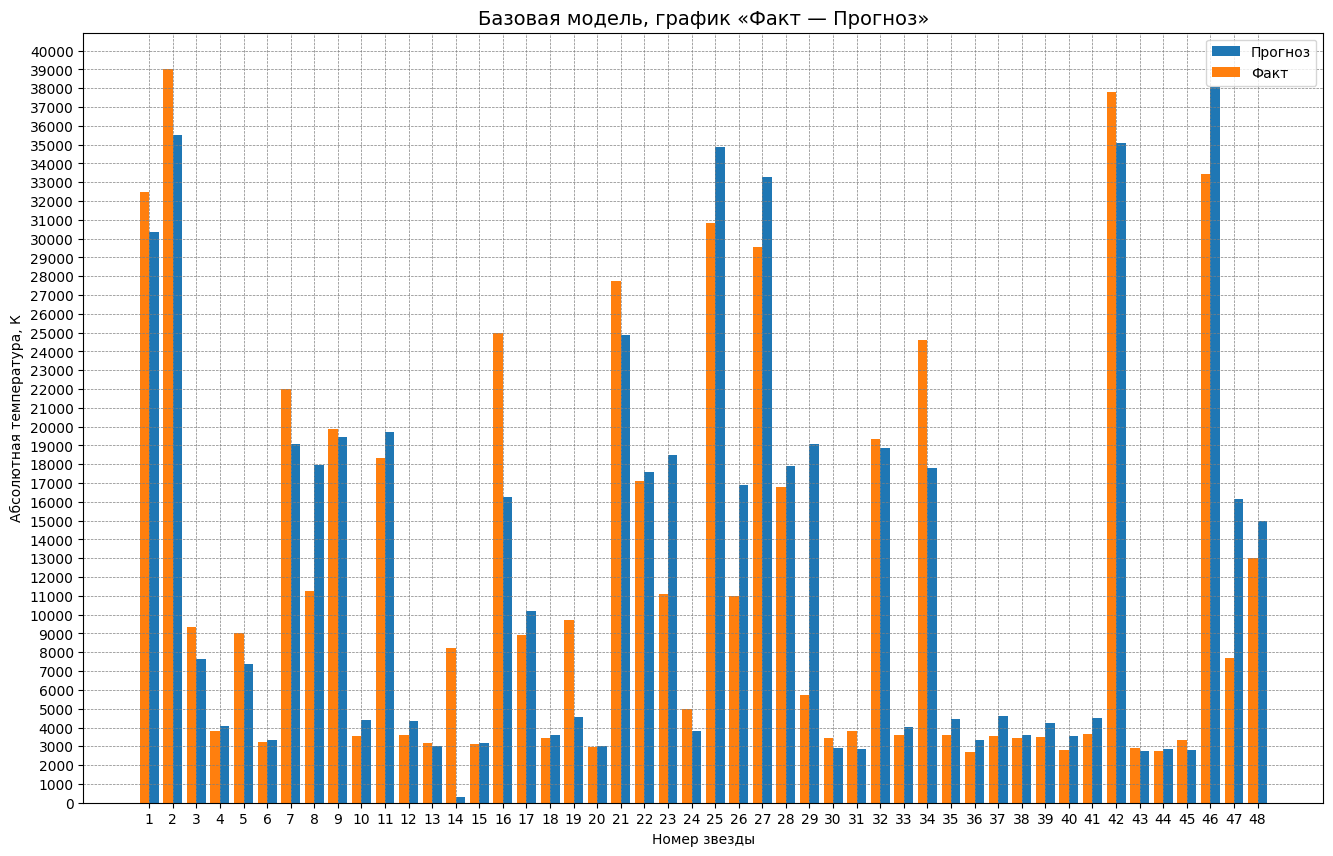

In [56]:
# Построим график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд,
# а по вертикальной — температура в Кельвинах
plt.figure(figsize=(16,10))
plt.grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
plt.title('Базовая модель, график «Факт — Прогноз»', fontsize=14)
x = np.arange(1, len(y_test)+1, 1)
y = base_net.forward(X_test).detach().cpu().numpy().flatten()
plt.xticks(x)
plt.yticks(range(0, 45000, 1000))
plt.ylabel('Абсолютная температура, К')
plt.xlabel('Номер звезды')
plt.bar(x, y, width=0.4, align='edge', label='Прогноз')
plt.bar(x, y_test.detach().cpu().numpy().flatten(), width=-0.4, align='edge', label='Факт')

plt.legend()
plt.show()

Вывод: в базовом варианте получена сеть, которая позволяет достичь целевого значения метрики. По графику "Факт-Прогноз" видно, что большая часть прогнозов не сильно отличаются от факта, при этом ряд значений (см. звёзды 14, 16, 19, 23, 29, 34, 47) сети не удалось предсказать точно.

## Улучшение нейронной сети

### Batch normalization

Создадим нейронную сеть с двумя скрытыми слоями, добавив слой с Batch normalization перед функцией активации в первый скрытый слой.

In [57]:
# Создадим класс для задания архитектуры нейронной сети
class Net_batch(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net_batch, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)

        return x

In [60]:
# Перебирая размер батча и количество нейронов в скрытых слоях найдём модель с лучшим значением метрики
num_epochs = 15000
learning_rate = 1.0e-3
for batch_size in [12, 24, 48, 60]:
    for n_hid_1 in [8, 16, 32]:
        for n_hid_2 in [8, 16, 32]:
            net_batch = Net_batch(27, n_hid_1, n_hid_2, 1).to(device)
            print('Hidden neurones: n_hid_1', n_hid_1, 'n_hid_2', n_hid_2, 'batch_size', batch_size)
            net_batch = train_net(net_batch, X_train, y_train, X_test, y_test, num_epochs, batch_size, learning_rate)
            print('end of variant')
            print()

Hidden neurones: n_hid_1 8 n_hid_2 8 batch_size 12
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  4163.0, best_rmse:  16084.0
эпоха 2000, rmse:  4528.0, best_rmse:  4163.0
Обучение закончилось с лучшим результатом (rmse):  4163.0
end of variant

Hidden neurones: n_hid_1 8 n_hid_2 16 batch_size 12
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  4676.0, best_rmse:  16084.0
эпоха 2000, rmse:  6693.0, best_rmse:  4676.0
Обучение закончилось с лучшим результатом (rmse):  4676.0
end of variant

Hidden neurones: n_hid_1 8 n_hid_2 32 batch_size 12
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  16084.0, best_rmse:  16084.0
Обучение закончилось с лучшим результатом (rmse):  16084.0
end of variant

Hidden neurones: n_hid_1 16 n_hid_2 8 batch_size 12
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  4756.0, best_rmse:  16084.0
эпоха 2000, rmse:  8000.0, best_rmse:  4756.0
Обучение закончилось с лучшим результатом (rmse):  4756.0
end o

эпоха 3000, rmse:  4414.0, best_rmse:  4568.0
эпоха 4000, rmse:  4583.0, best_rmse:  4414.0
Обучение закончилось с лучшим результатом (rmse):  4414.0
end of variant

Hidden neurones: n_hid_1 8 n_hid_2 32 batch_size 60
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  4572.0, best_rmse:  16084.0
эпоха 2000, rmse:  4473.0, best_rmse:  4572.0
эпоха 3000, rmse:  4199.0, best_rmse:  4473.0
эпоха 4000, rmse:  4844.0, best_rmse:  4199.0
Обучение закончилось с лучшим результатом (rmse):  4199.0
end of variant

Hidden neurones: n_hid_1 16 n_hid_2 8 batch_size 60
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  4712.0, best_rmse:  16084.0
эпоха 2000, rmse:  4493.0, best_rmse:  4712.0
эпоха 3000, rmse:  4470.0, best_rmse:  4493.0
эпоха 4000, rmse:  4914.0, best_rmse:  4470.0
Обучение закончилось с лучшим результатом (rmse):  4470.0
end of variant

Hidden neurones: n_hid_1 16 n_hid_2 16 batch_size 60
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  4508.

Удалось улучшить результат. Наилучший результат получился 3682 К получен при размере батча 48, количестве нейронов в первом скрытом слое 8, во втором скрытом слое - 32.

In [67]:
num_epochs = 15000
batch_size = 48
learning_rate = 2.0e-4
net_batch = Net_batch(27, 8, 32, 1).to(device)
net_batch = train_net(net_batch, X_train, y_train, X_test, y_test, num_epochs, batch_size, learning_rate)

эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  15153.0, best_rmse:  16084.0
эпоха 2000, rmse:  11695.0, best_rmse:  15153.0
эпоха 3000, rmse:  6504.0, best_rmse:  11695.0
эпоха 4000, rmse:  4540.0, best_rmse:  6504.0
эпоха 5000, rmse:  4456.0, best_rmse:  4540.0
эпоха 6000, rmse:  4255.0, best_rmse:  4456.0
эпоха 7000, rmse:  4047.0, best_rmse:  4255.0
эпоха 8000, rmse:  3978.0, best_rmse:  4047.0
эпоха 9000, rmse:  4069.0, best_rmse:  3978.0
Обучение закончилось с лучшим результатом (rmse):  3978.0


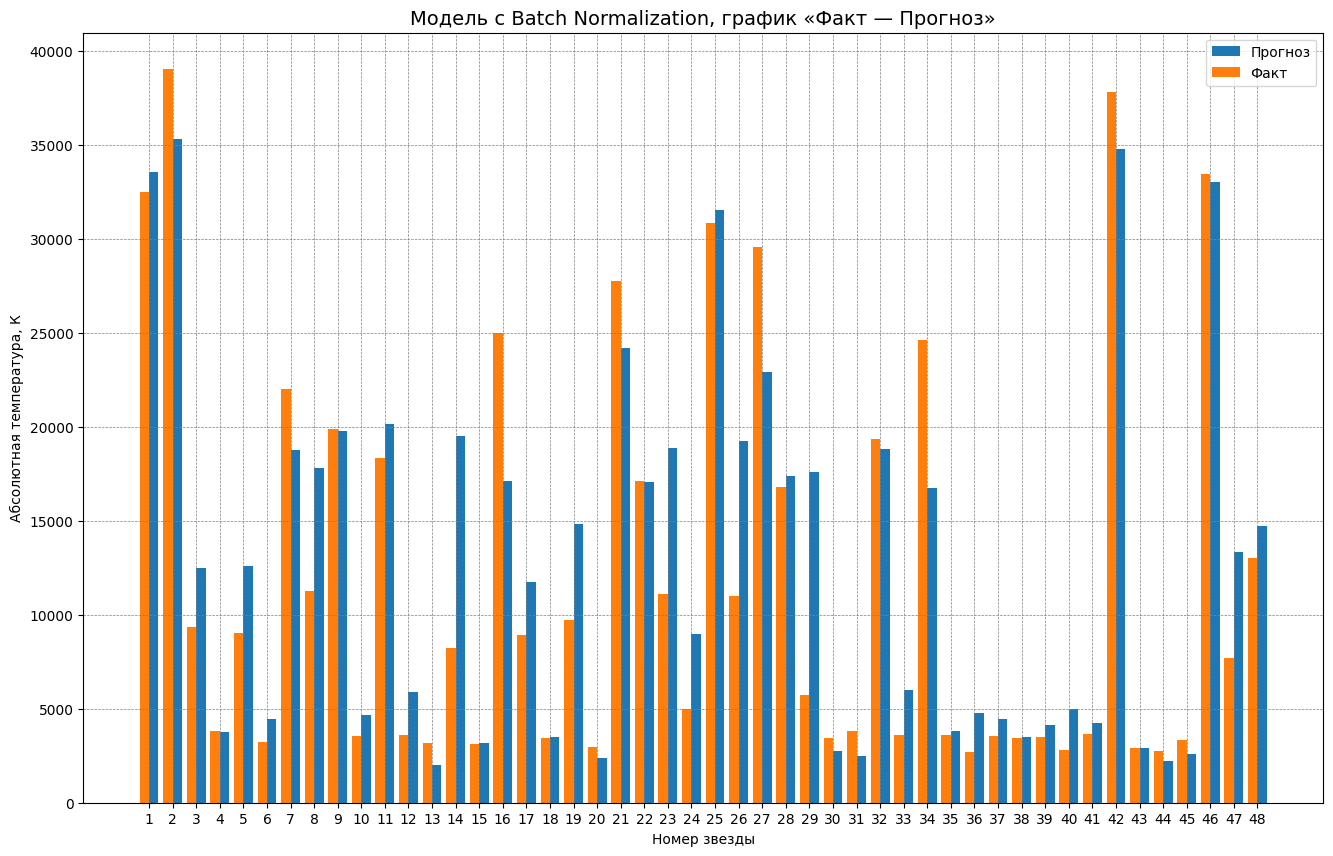

In [69]:
# Построим график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд,
# а по вертикальной — температура в Кельвинах
plt.figure(figsize=(16,10))
plt.grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
plt.title('Модель с Batch Normalization, график «Факт — Прогноз»', fontsize=14)
x = np.arange(1, len(y_test)+1, 1)
y = net_batch.forward(X_test).detach().cpu().numpy().flatten()
plt.xticks(x)
plt.yticks(range(0, 80000, 5000))
plt.ylabel('Абсолютная температура, К')
plt.xlabel('Номер звезды')
plt.bar(x, y, width=0.4, align='edge', label='Прогноз')
plt.bar(x, y_test.detach().cpu().numpy().flatten(), width=-0.4, align='edge', label='Факт')

plt.legend()
plt.show()

Полученная модель не смогла точно предсказать температуру для звёзд 2, 16, 19, 21, 23, 26, 27, 29, 34, 47.

### Dropout

In [70]:
# Создадим класс для задания архитектуры нейронной сети
class Net_dropout(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons, p):
        super(Net_dropout, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp = nn.Dropout(p=p)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.dp(x)
        x = self.act1(x)

        x = self.fc2(x)
        x = self.act2(x)

        x = self.fc3(x)
        x = self.act3(x)

        return x

In [72]:
# Перебирая долю выключаемых нейронов и количество нейронов в скрытых слоях найдём модель с лучшим значением метрики
num_epochs = 15000
learning_rate = 1.0e-3
batch_size = 48
for p in np.arange(0.4, 0.81, 0.2):
    for n_hid_1 in [8, 16, 32]:
        for n_hid_2 in [8, 16, 32]:
            net_dropout = Net_dropout(27, n_hid_1, n_hid_2, 1, p).to(device)
            print('Hidden neurones: n_hid_1', n_hid_1, 'n_hid_2', n_hid_2, 'p', p)
            net_dropout = train_net(net_dropout, X_train, y_train, X_test, y_test, num_epochs, batch_size, learning_rate)
            print('end of variant')
            print()

Hidden neurones: n_hid_1 8 n_hid_2 8 p 0.4
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  7398.0, best_rmse:  16084.0
эпоха 2000, rmse:  5892.0, best_rmse:  7398.0
эпоха 3000, rmse:  5596.0, best_rmse:  5892.0
эпоха 4000, rmse:  5464.0, best_rmse:  5596.0
эпоха 5000, rmse:  5391.0, best_rmse:  5464.0
эпоха 6000, rmse:  5322.0, best_rmse:  5391.0
эпоха 7000, rmse:  5256.0, best_rmse:  5322.0
эпоха 8000, rmse:  5191.0, best_rmse:  5256.0
эпоха 9000, rmse:  5160.0, best_rmse:  5191.0
эпоха 10000, rmse:  5115.0, best_rmse:  5160.0
эпоха 11000, rmse:  5041.0, best_rmse:  5115.0
эпоха 12000, rmse:  4987.0, best_rmse:  5041.0
эпоха 13000, rmse:  4975.0, best_rmse:  4987.0
эпоха 14000, rmse:  4896.0, best_rmse:  4975.0
эпоха 14999, rmse:  4881.0, best_rmse:  4896.0
end of variant

Hidden neurones: n_hid_1 8 n_hid_2 16 p 0.4
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  7302.0, best_rmse:  16084.0
эпоха 2000, rmse:  5855.0, best_rmse:  7302.0
эпоха 3000, rmse:

эпоха 1000, rmse:  6765.0, best_rmse:  16084.0
эпоха 2000, rmse:  5660.0, best_rmse:  6765.0
эпоха 3000, rmse:  5577.0, best_rmse:  5660.0
эпоха 4000, rmse:  5477.0, best_rmse:  5577.0
эпоха 5000, rmse:  5377.0, best_rmse:  5477.0
эпоха 6000, rmse:  5319.0, best_rmse:  5377.0
эпоха 7000, rmse:  5232.0, best_rmse:  5319.0
эпоха 8000, rmse:  5188.0, best_rmse:  5232.0
эпоха 9000, rmse:  5088.0, best_rmse:  5188.0
эпоха 10000, rmse:  5040.0, best_rmse:  5088.0
эпоха 11000, rmse:  4987.0, best_rmse:  5040.0
эпоха 12000, rmse:  4998.0, best_rmse:  4987.0
Обучение закончилось с лучшим результатом (rmse):  4987.0
end of variant

Hidden neurones: n_hid_1 16 n_hid_2 32 p 0.6000000000000001
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  16084.0, best_rmse:  16084.0
Обучение закончилось с лучшим результатом (rmse):  16084.0
end of variant

Hidden neurones: n_hid_1 32 n_hid_2 8 p 0.6000000000000001
эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  6540.0, best_rmse: 

эпоха 1000, rmse:  6127.0, best_rmse:  16084.0
эпоха 2000, rmse:  5671.0, best_rmse:  6127.0
эпоха 3000, rmse:  5596.0, best_rmse:  5671.0
эпоха 4000, rmse:  5472.0, best_rmse:  5596.0
эпоха 5000, rmse:  5403.0, best_rmse:  5472.0
эпоха 6000, rmse:  5273.0, best_rmse:  5403.0
эпоха 7000, rmse:  5233.0, best_rmse:  5273.0
эпоха 8000, rmse:  5220.0, best_rmse:  5233.0
эпоха 9000, rmse:  5181.0, best_rmse:  5220.0
эпоха 10000, rmse:  5045.0, best_rmse:  5181.0
эпоха 11000, rmse:  5096.0, best_rmse:  5045.0
Обучение закончилось с лучшим результатом (rmse):  5045.0
end of variant



Результат улучшить не удалось. Наилучший показатель 4375 К получен при 16 и 32 нейронах в первом и втором скрытом слоях соответственно и при доле отключаемых нейронов 0.4 (размер батча 48).

In [75]:
num_epochs = 15000
batch_size = 48
learning_rate = 5.0e-4
net_dropout = Net_dropout(27, 16, 32, 1, 0.4).to(device)
net_dropout = train_net(net_dropout, X_train, y_train, X_test, y_test, num_epochs, batch_size, learning_rate)

эпоха 0, rmse:  16084.0, best_rmse:  39000.0
эпоха 1000, rmse:  7373.0, best_rmse:  16084.0
эпоха 2000, rmse:  5784.0, best_rmse:  7373.0
эпоха 3000, rmse:  5445.0, best_rmse:  5784.0
эпоха 4000, rmse:  5310.0, best_rmse:  5445.0
эпоха 5000, rmse:  5200.0, best_rmse:  5310.0
эпоха 6000, rmse:  5173.0, best_rmse:  5200.0
эпоха 7000, rmse:  5140.0, best_rmse:  5173.0
эпоха 8000, rmse:  5082.0, best_rmse:  5140.0
эпоха 9000, rmse:  5031.0, best_rmse:  5082.0
эпоха 10000, rmse:  4994.0, best_rmse:  5031.0
эпоха 11000, rmse:  4960.0, best_rmse:  4994.0
эпоха 12000, rmse:  4890.0, best_rmse:  4960.0
эпоха 13000, rmse:  4880.0, best_rmse:  4890.0
эпоха 14000, rmse:  4844.0, best_rmse:  4880.0
эпоха 14999, rmse:  4823.0, best_rmse:  4844.0


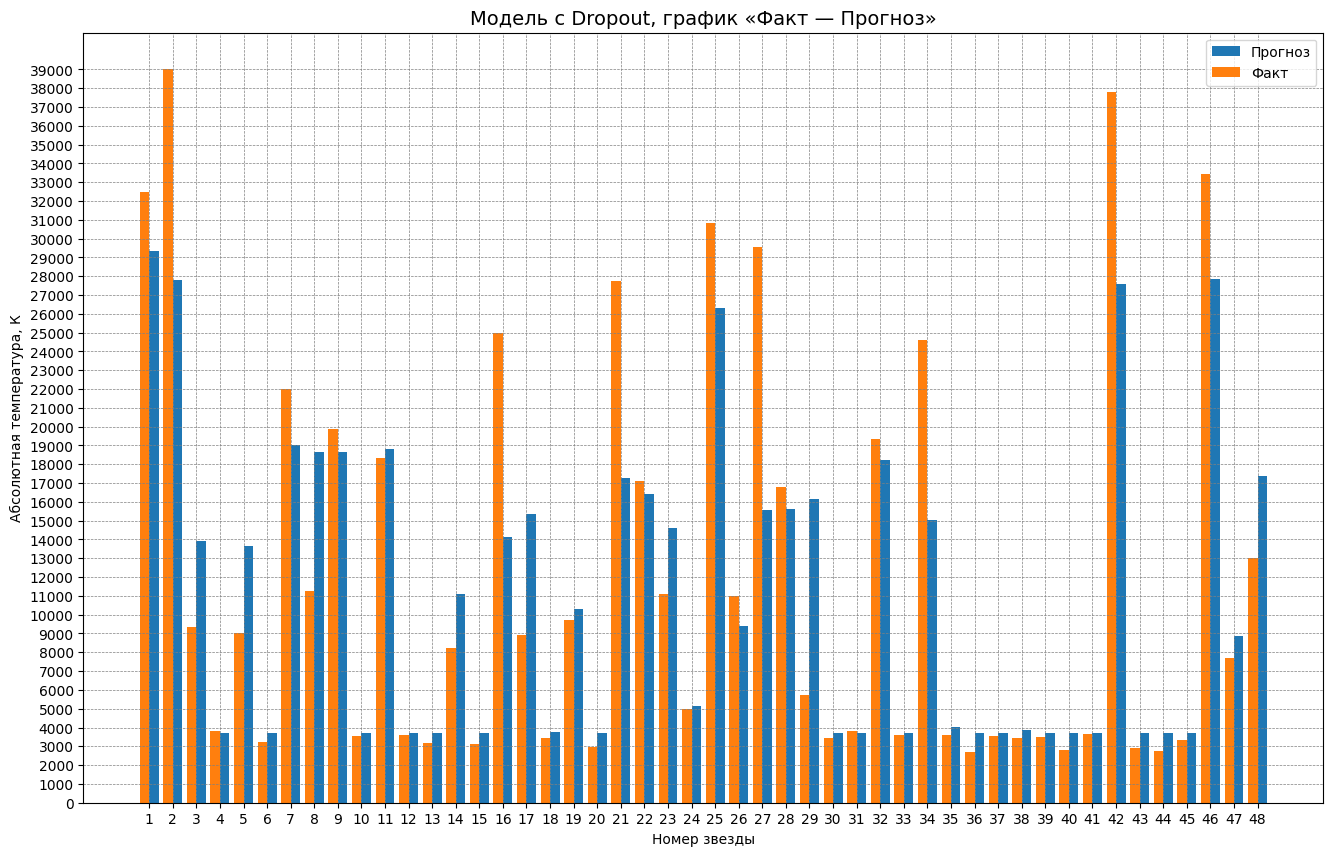

In [76]:
# Построим график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд,
# а по вертикальной — температура в Кельвинах
plt.figure(figsize=(16,10))
plt.grid(color='gray', linewidth = 0.5, linestyle = '--', which='both')
plt.title('Модель с Dropout, график «Факт — Прогноз»', fontsize=14)
x = np.arange(1, len(y_test)+1, 1)
y = net_dropout.forward(X_test).detach().cpu().numpy().flatten()
plt.xticks(x)
plt.yticks(range(0, 40000, 1000))
plt.ylabel('Абсолютная температура, К')
plt.xlabel('Номер звезды')
plt.bar(x, y, width=0.4, align='edge', label='Прогноз')
plt.bar(x, y_test.detach().cpu().numpy().flatten(), width=-0.4, align='edge', label='Факт')

plt.legend()
plt.show()

Полученная сеть склонна занижать температуру для звёзд с температурой выше 15000 К.

## Выводы

В работе на основе данных о звёздах разработана нейронная сеть, позволяющая предсказать абсолютную температуру звезды.

В ходе предобработки данных выполнено:
- загрузка и ознакомление с данными,
- обработка неявных дубликатов,
- анализ аномалий,
- разработка дополнительных признаков,
- кодирование категориальных и масштабирование числовых признаков.

Перебором вариантов количества скрытых слоёв и количества нейронов в них выбрана архитектура сети, обеспечивающая наилучшее значение целевой метрики (базовая нейронная сеть).

С использованием такой же архитектуры, как у базовой сети, проработано использование Batch Normalization и Dropout. Достичь лучшего значения метрики, чем в базовой нейроннйо сети, не удалось. 